# Tesseractとpytesseractで文字認識する(2021.7.6)

**Summary**<br>

tesseractをPythonから呼び出してキャプチャ画像から文字認識する


## Tesseractコマンドライン版の動作確認

詳細は[TesseractとPyOCRで文字認識する(2021.7.3)](./test_pyocr.html)を参照

```
brew install tesseract
brew install tesseract-lang

tessearact --list-langs
ls /usr/local/Cellar/tesseract/4.1.1/share/tessdata
```

実行はoutと指定するとout.txtというファイル名で出力される。<br>
末尾に勝手に".txt"が付与される。

```
tesseract input.png out -l jpn+eng
```


## 今回はPyOCRではなくPytesseractを使って呼び出す

pytesseractをインストールしておく

```
pip install pytesseract
```

[TesseractとPyOCRで文字認識する(2021.7.3)](./test_pyocr.html)と同様に、
次のような書きかけのMarkdownファイルをキャプチャして認識してみた。

![Markdownの画像](./test_pytesseract_res/infile.png)


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =======================================================
#  tesseractとpytesseractを使って画像ファイルをOCRするスクリプト
#
#  test_pytesseract.py
#  coded by Noboru Harada (noboru@ieee.org)
#
#  Changes:
#  2021/07/06: First version
# =======================================================

import re
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from operator import itemgetter, attrgetter

In [2]:
# input file
IMG_DIR = './'
filename_img = 'infile.png' 

# text cleansing mode (0: None, 1: remove white space, 2: full cleansing)
mode = 1

### Pytesseractで文字認識を行うテスト（OpenCVを用いた前処理を試す）

以下のようなフィルターを試す
- grayscaling
- thresholding
- dilating
- eroding
- opening
- canny edge detection
- noise removal
- deskwing
- template matching.  

In [3]:
###################################
# define preprocessing functions
###################################

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

#zoom
def resize(image, gain):
    h, w = image.shape[:2]
    inter = cv2.INTER_LINEAR
    #inter = cv2.INTER_NEAREST
    return cv2.resize(image, (w * gain, h * gain), interpolation=inter)

#find squares
def find_squares(image):
    return image

#clean up text
def clean_text(mode, intext):
    text = intext
    if mode == 1: # reduce multiple white spaces into one
        text = re.sub(r'[　 \t]+', ' ', intext)
    elif mode == 2: # cleansing middle spaces in multi-byte characters and remove leading and trailing spaces
        # format reguralization for Japanese char-set
        text = re.sub('([あ-んア-ン一-龥ー、。]) +((?=[あ-んア-ン一-龥ー、。]))', r'\1\2', intext)
        # remove multiple spaces
        text = re.sub(r'[　 \t]+', ' ', text)
        # remove leading and trailing space, 2-byte space and tab space
        text = re.sub(r'^[ 　\t]+', '', text)
        text = re.sub(r'(\| )|([\r\n|\n|\r]) +', r'\1\2', text)
    return text

###################################

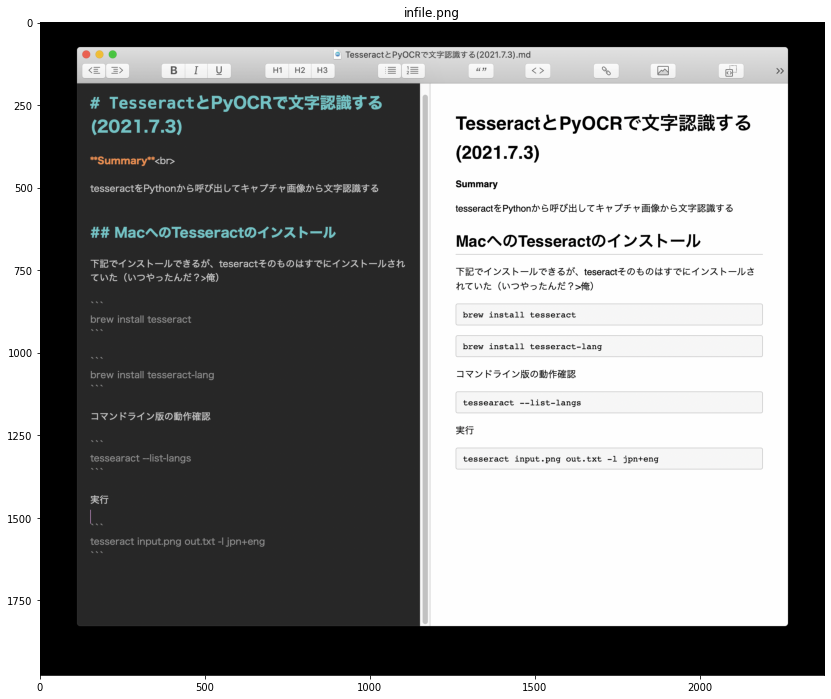

In [4]:
# open input image
image = cv2.imread(IMG_DIR + filename_img)

# plot original image
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title(filename_img)

plt.show()

In [5]:
# Preprocess image
image2 = resize(image, 2)
gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

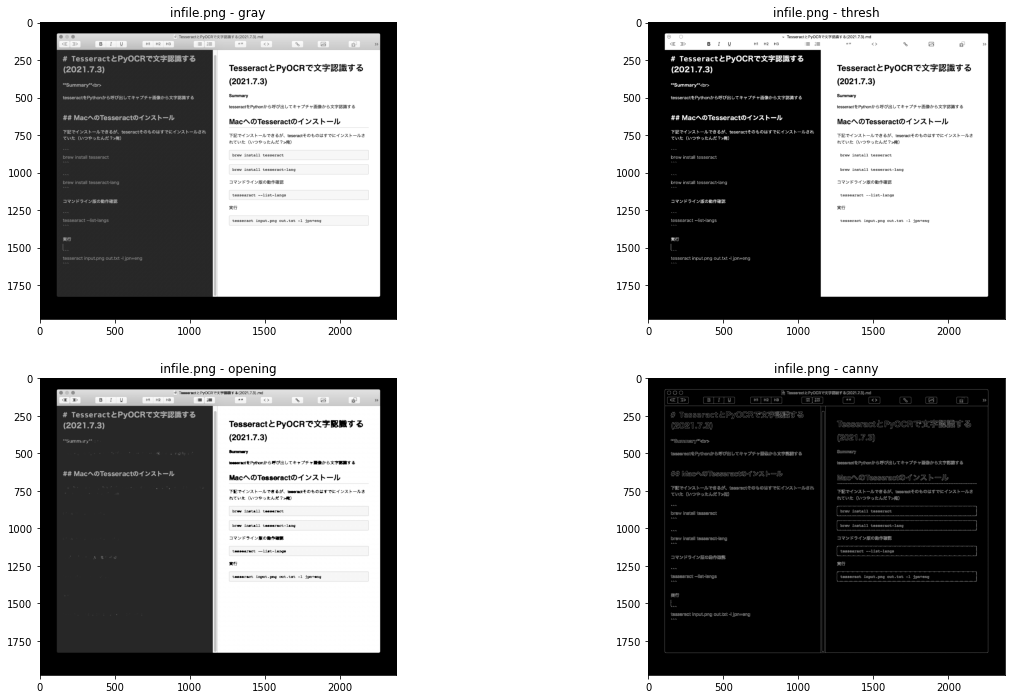

In [6]:
# Plot images after preprocessing
fig = plt.figure(figsize=(20,12))
ax = []
rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(filename_img + ' - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')   

In [7]:
# Get OCR output using Pytesseract
custom_config = r'-l jpn --oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(clean_text(mode, pytesseract.image_to_string(image, config=custom_config)))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(clean_text(mode, pytesseract.image_to_string(thresh, config=custom_config)))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(clean_text(mode, pytesseract.image_to_string(opening, config=custom_config)))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(clean_text(mode, pytesseract.image_to_string(canny, config=custom_config)))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> ZOOMed IMAGE')
print('-----------------------------------------')
print(clean_text(mode, pytesseract.image_to_string(image2, config=custom_config)))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
人@W $ TesseractとPyOCRで文字認識する(2021.7.3) .md
<写 = B 7 U H1 H2 H3 還員等 2 ぐッ S、 加 還: >>
ト ェ=デミ刃ミド
TesseractとPyOCRで文字認識する
に1「 (10に1 Akさりと2 (2021 ・7.3)
tesseractをPythonから呼び出してキャプチャ画像から文字認識する Summary
tesseractをPythonから呼び出してキャプチャ画像から文字認識する
MacへのTesseractのインストール
下記でインストールできるが、teseractそのものはすでにインストールされ _ 、
ていた (いつやったんだ?>俺) 下記でインストールできるが、teseractそのものはすでにインストールさ
1 れていた (いつやったんだ?>俺)
brew install tesseract CO 議にOOo
brew 1nsta11 tesseract-]ang
brew install tesseract-lang コマンドライン版の動作確認
もtessearao --1]1st-]angS
コマンドライン版の動作確認
実行
tessearact --list-langs tesSserao 1nput.png out.もxt -1 ]pn+eng
Ep
tesseract input.png out.txt -| jpn+eng


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
② 〇 = TesseractとPyOCRで文字認識する(2021.7.3).md
<三 且> B 『 U H1 H2 H3 計 乱 カ く> SQ、 愉 還: >>
# TesseractとPyOCRで文字認識する
マミ丸謀

(2021.7.3) Tesserac